# App Store Case Study
by: Andrew Yew andrewyewcy@gmail.com, last updated: 2022-06-16

### <u> Summary</u>
With limited manpower for app development, this study examines if there is a significant difference in app ratings between Google Play Store and Apple App Store to determine which store should an app be developed for to get higher ratings. A permutation test was performed on data gathered from both app stores to verify the observed difference between the two app stores. In conclusion, Google Play Store was observed to have a mean rating of 4.174, which was 0.124 higher than the mean rating of 4.050 for the Apple App Store. This difference was confirmed to be not due to randomness with a p-value of 0 from 10,000 replicates. Thus, it is recommended that the app be developed for the Google Play Store first.

### <u>Methodology</u>
**1) Problem Identification**  
Due to limited manpower, the app can only be developed for either the Apple App Store or the Google Play Store. The Key Performance Index(KPI) for app development is the average rating of the app. It is assumed that the largest factor affecting average app rating is the store. Thus, verification is needed on the difference of average app ratings between stores, and, if it is significant, which store should be prioritized for app development.

**2) Data Acquisition**  
The web scraped data for both app stores were accessed from Kaggle ([Apple App Data](https://www.kaggle.com/datasets/ramamet4/app-store-apple-data-set-10k-apps?resource=download), [Google App Data](https://www.kaggle.com/lava18/google-play-store-apps)).

**3) Data Pre-processing**  
Data wrangling was performed using the Pandas library. Only relevant variables(columns) were selected. Apps without ratings or reviews were removed from analysis. 

**4) Exploratory Data Analysis**  
Histograms and boxplots were used to examine the distributions of app ratings between the Google and Apple stores. As app ratings were found to be not normally distributed, the non-parametric test of permutation testing was used.

**5) Modeling (Null Hypothesis and Permutation Test)**  
The test statistic was determined to be the difference of means for the app ratings between stores. The app stores were fixed while the numpy random permutation function was used to scramble the app ratings. 10,000 replicates of the test statistic were generated to calculate the p-value for the null hypothesis.

In [1]:
# Importing python modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
sns.set_style()
sns.set_palette('colorblind')

from scipy import stats

## Step 2: Data Acquisition

##### Google Play Store Data

In [2]:
google = "data/googleplaystore.csv"
df = pd.read_csv(google)

# tidying dataframe columns to ensure consistent capitalization and no spaces or non-alphabet characters
old_columns = pd.DataFrame(list(df.columns),columns = ["old"])
old_columns['new']= old_columns.old.str.replace('[^\w\s]','',regex = True).str.replace(' ','_').str.lower()
df.rename(columns = dict(zip(old_columns.old,old_columns.new)), inplace =True)

# Comparing with the Apple App Store data, 
# only the below columns found to be useful and the rest were dropped.
google_df = df[['app','category','rating','reviews','size','price']]
google_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   app       10841 non-null  object 
 1   category  10841 non-null  object 
 2   rating    9367 non-null   float64
 3   reviews   10841 non-null  object 
 4   size      10841 non-null  object 
 5   price     10841 non-null  object 
dtypes: float64(1), object(5)
memory usage: 508.3+ KB


##### Apple App Store data

In [3]:
apple = "data/AppleStore.csv"
df = pd.read_csv(apple)

# tidying dataframe columns to ensure consistent capitalization and no spaces or non-alphabet characters
old_columns = pd.DataFrame(list(df.columns),columns = ["old"])
old_columns['new']= old_columns.old.str.replace('[^\w\s]','',regex = True).str.replace(' ','_').str.lower()
df.rename(columns = dict(zip(old_columns.old,old_columns.new)), inplace =True)

# Comparing with the Google Play Store data, 
# only the below columns found to be useful and the rest were dropped.
apple_df = df[['track_name','prime_genre','user_rating','rating_count_tot','price','size_bytes']]
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7197 entries, 0 to 7196
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        7197 non-null   object 
 1   prime_genre       7197 non-null   object 
 2   user_rating       7197 non-null   float64
 3   rating_count_tot  7197 non-null   int64  
 4   price             7197 non-null   float64
 5   size_bytes        7197 non-null   int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 337.5+ KB


## Step 3: Data Pre-processing

### Cleaning Google Play Store data
Observing the data types of each column with reference to the first few rows:  
a) 'reviews' should be an integer instead of object  
b) 'size' should be an integer or float instead of object  
c) 'price' should be integer or float instead of object  

##### a) Cleaning 'reviews'

In [4]:
# Filtering all rows where review is not a number
google_df.loc[google_df.reviews.str.isnumeric()==False]

,app,category,rating,reviews,size,price
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Everyone


In [5]:
# upon closer inspection, row's data does not make sense and is therefore dropped
print("Size before dropping: ", google_df.shape)
google_df.drop(google_df.loc[google_df.reviews.str.isnumeric()==False].index, inplace = True)
google_df.reset_index(drop = True, inplace = True);
print("Size after dropping: ", google_df.shape)

# convert df reviews to integer type
google_df.reviews = google_df.reviews.astype('int64')

Size before dropping:  (10841, 6)
Size after dropping:  (10840, 6)


##### b) Cleaning 'size'  
The size column was observed to contain various units of size, such as kilobytes and megabytes. All units were converted to bytes to ensure consistency.

In [6]:
google_df['size'].head()

0     19M
1     14M
2    8.7M
3     25M
4    2.8M
Name: size, dtype: object

To better understand how many size units were used, the units were extracted and grouped for counting. It was found that 1,695 out of 10,840 apps have "Varies with device" as size. The size for these apps were replaced to be null. 

In [7]:
google_df['size_unit'] = google_df['size'].str.lower().str[-1]
google_df['numbers']= google_df['size'].str.extract('(\d+)').astype(float)
google_df['size_unit'].groupby(google_df['size_unit']).value_counts().sort_values(ascending=False)

size_unit  size_unit
m          m            8829
e          e            1695
k          k             316
Name: size_unit, dtype: int64

In [8]:
# creating a new column to store converted size
google_df['size_bytes'] = np.NaN

# loop to convert each size into bytes or null values
for row in range(len(google_df)):
    if google_df.loc[row,'size_unit'] == 'k':
        google_df.loc[row,'size_bytes'] = google_df.loc[row,'numbers']*1000
    elif google_df.loc[row,'size_unit'] == 'm':
        google_df.loc[row,'size_bytes'] = google_df.loc[row,'numbers']*1000000
    else: google_df.loc[row,'size_bytes'] = 0

In [9]:
# dropping all columns aside from converted size
google_df.drop(['size_unit','numbers', 'size'], inplace = True, axis = 1)
google_df.size_bytes = google_df.size_bytes.astype('int64')

##### c) Cleaning 'price'  
The price column was observed to contain non-numeric characters. These characters were removed and the data type converted to float.

In [10]:
google_df.price.unique()

array(['0', '$4.99', '$3.99', '$6.99', '$1.49', '$2.99', '$7.99', '$5.99',
       '$3.49', '$1.99', '$9.99', '$7.49', '$0.99', '$9.00', '$5.49',
       '$10.00', '$24.99', '$11.99', '$79.99', '$16.99', '$14.99',
       '$1.00', '$29.99', '$12.99', '$2.49', '$10.99', '$1.50', '$19.99',
       '$15.99', '$33.99', '$74.99', '$39.99', '$3.95', '$4.49', '$1.70',
       '$8.99', '$2.00', '$3.88', '$25.99', '$399.99', '$17.99',
       '$400.00', '$3.02', '$1.76', '$4.84', '$4.77', '$1.61', '$2.50',
       '$1.59', '$6.49', '$1.29', '$5.00', '$13.99', '$299.99', '$379.99',
       '$37.99', '$18.99', '$389.99', '$19.90', '$8.49', '$1.75',
       '$14.00', '$4.85', '$46.99', '$109.99', '$154.99', '$3.08',
       '$2.59', '$4.80', '$1.96', '$19.40', '$3.90', '$4.59', '$15.46',
       '$3.04', '$4.29', '$2.60', '$3.28', '$4.60', '$28.99', '$2.95',
       '$2.90', '$1.97', '$200.00', '$89.99', '$2.56', '$30.99', '$3.61',
       '$394.99', '$1.26', '$1.20', '$1.04'], dtype=object)

In [11]:
google_df.price = google_df.price.str.replace('$', '',regex =False)
google_df.price = google_df.price.astype(float)

##### Reviewing cleaned Google data

In [12]:
# Dropping null ratings, 0 reviews, and size = 0
print("Size before dropping: ", google_df.shape)
google_df.drop(google_df.loc[(google_df['rating'].isnull() == True) | 
                             (google_df['reviews'] == 0) | 
                             (google_df['size_bytes'] == 0)].index, inplace = True)
google_df.reset_index(drop = True, inplace = True);
print("Size after dropping: ", google_df.shape)

google_df.info()

Size before dropping:  (10840, 6)
Size after dropping:  (7729, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7729 entries, 0 to 7728
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   app         7729 non-null   object 
 1   category    7729 non-null   object 
 2   rating      7729 non-null   float64
 3   reviews     7729 non-null   int64  
 4   price       7729 non-null   float64
 5   size_bytes  7729 non-null   int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 362.4+ KB


### Cleaning Apple App Store data
As the data types for the Apple App Store data are already as needed, only the columns were renamed for consistency with Google Play Store.

In [13]:
apple_df = apple_df.rename(columns = dict(zip(apple_df.columns,list(google_df.columns))))

##### Reviewing cleaned Apple data

In [14]:
# Dropping null ratings, 0 reviews, and size = 0
print("Size before dropping: ", apple_df.shape)
apple_df.drop(apple_df.loc[(apple_df['rating'].isnull() == True) | 
                             (apple_df['reviews'] == 0) | 
                             (apple_df['size_bytes'] == 0)].index, inplace = True)
apple_df.reset_index(drop = True, inplace = True);
print("Size after dropping: ", apple_df.shape)

apple_df.info()

Size before dropping:  (7197, 6)
Size after dropping:  (6268, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6268 entries, 0 to 6267
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   app         6268 non-null   object 
 1   category    6268 non-null   object 
 2   rating      6268 non-null   float64
 3   reviews     6268 non-null   int64  
 4   price       6268 non-null   float64
 5   size_bytes  6268 non-null   int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 293.9+ KB


### Combining app data from both Apple and Google

In [15]:
google_df['store'] = "google"
apple_df['store'] = "apple"

print("Google data size before append: ", google_df.shape)
print("Apple data size before append: ", apple_df.shape)
app_df = pd.concat([google_df, apple_df])
app_df.reset_index(drop = True, inplace = True)
print("Size after append: ", app_df.shape)

Google data size before append:  (7729, 7)
Apple data size before append:  (6268, 7)
Size after append:  (13997, 7)


In [16]:
app_df.to_csv('processed_data/app_data_clean.csv', index = False, encoding = 'utf-8')              

## Step 4 Exploratory Data Analysis

The Google store has a mean app rating of 4.174, 0.124 higher than Apple store's mean app rating of 4.050.

As the difference of means is quite small, 0.124 or 3.06% higher than Apple App Store, it is reasonable to doubt if difference is due to randomness. Thus, a statistical test is needed to confirm significane of observed difference of mean.

In [17]:
app_df.groupby(by = "store").rating.describe().T.round(3)

store,apple,google
count,6268.000,7729.000
mean,4.050,4.174
std,0.727,0.545
min,1.000,1.000
25%,4.000,4.000
50%,4.500,4.300
75%,4.500,4.500
max,5.000,5.000


The test statistic is the difference of means for ratings between the Apple and the Google stores.

To appropriately select a suitable testing method, the distributions of app ratings between Apple and Google were examined using histograms and boxplots.

It was observed that app ratings are not normally distributed, meaning that a non-parametric test should be used.

Furthermore, the interquartile range (IQR) for both stores are between 4 and 4.5.

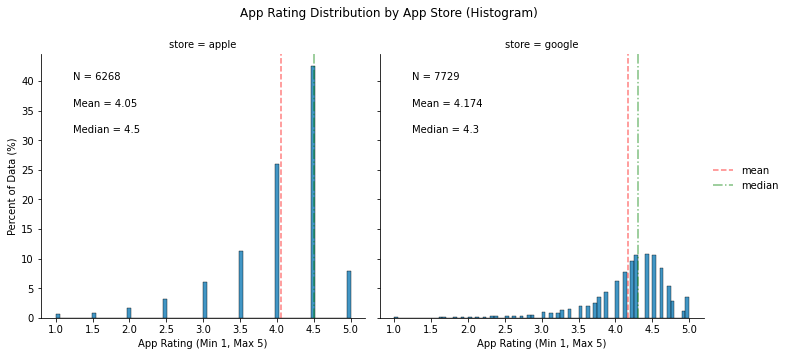

In [18]:
#https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
g = sns.FacetGrid(app_df[['rating','store']], col = 'store', col_order = list(app_df.store.sort_values().unique()),height = 5)

def mean_median_line(data, **kws):
    mean = data.rating.mean()
    median = data.rating.median()
    ax = plt.gca()
    ax.axvline(x = mean, c = 'r', linestyle = '--', alpha = 0.5, label = "mean")
    ax.axvline(x = median, c = 'g', linestyle = '-.', alpha = 0.5, label = "median")
    
    n =len(data)    
    ax.text(0.1, 0.9, f"N = {n}", transform = ax.transAxes)
    ax.text(0.1, 0.8, f"Mean = {round(mean,3)}", transform = ax.transAxes)
    ax.text(0.1, 0.7, f"Median = {round(median,3)}", transform = ax.transAxes)
    
g.map_dataframe(sns.histplot,'rating', stat = "percent")
g.map_dataframe(mean_median_line)
g.add_legend()
g.set_axis_labels("App Rating (Min 1, Max 5)","Percent of Data (%)")
g.fig.subplots_adjust(top = 0.85)
g.fig.suptitle('App Rating Distribution by App Store (Histogram)')
plt.show

#fig = g.get_figure()
plt.savefig('App Rating Distribution by App Store_Histogram.png',
            dpi = 300, 
            format = 'png')

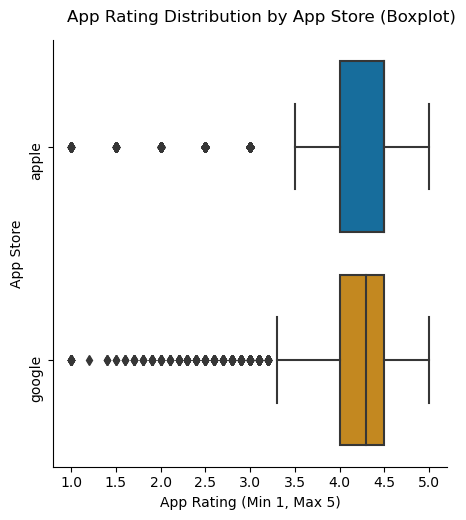

In [19]:
_ = sns.catplot(data = app_df,
                x = 'rating',
                kind = 'box',
                y = 'store',
                order = list(app_df.store.sort_values().unique())
               )
_.fig.suptitle("App Rating Distribution by App Store (Boxplot)",
                x= 0.6, y= 1.03)
_.set(xlabel = "App Rating (Min 1, Max 5)",
      ylabel = "App Store")
plt.yticks(rotation = 90)

plt.savefig('App Rating Distribution by App Store_Boxplot.png',
            dpi = 300, 
            format = 'png')
plt.show()

Further numerical testing also verified that the distributions are not normal.

In [20]:
apple_normal = stats.normaltest(app_df['rating'][app_df.store == 'apple'])
google_normal = stats.normaltest(app_df['rating'][app_df.store == 'google'])
print('The D’Agostino and Pearson’s normality test yielded p-values:')
print('Apple: ', apple_normal[1])
print('Google: ', google_normal[1])
print('The p-value of 0 from both tests confirms the visual observation that app ratings are not normally distributed')

The D’Agostino and Pearson’s normality test yielded p-values:
Apple:  0.0
Google:  0.0
The p-value of 0 from both tests confirms the visual observation that app ratings are not normally distributed


## Step 5 Modeling (Null Hypothesis and Permutation Test)

#### <u>Null hypothesis</u>:

**H<sub>null</sub>**: the observed difference in the mean app rating between Apple and Google store is due to randomness and is not significant.

**H<sub>alternative</sub>**: the observed difference in the mean app rating between Apple and Google store is **not** due to chance and **is** significant.

#### <u>Testing procedure</u>:
1. Assume that the app stores of Google and Apple have no impact on rating.
2. While keeping the store constant, the rating column was shuffled. Based on aforementioned assumption, the null hypothesis is not proven false if the replicate of the test statistic, the difference of app rating means between stores, is at least the observed difference of 0.124.
3. 10,000 replicate samples and replicates were taken.

Begin by defining functions that perform all of the above procedures:

In [21]:
def diff_of_mean(data1, data2, func = np.mean):
    """ Test statistic for difference of means"""
    return func(data2)-func(data1)

def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

def draw_permutation_replicates(data_1, data_2, func, size =1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1,data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)

    return perm_replicates

Perform the permutation test and generate 10,000 replicates.

In [22]:
apple = app_df.rating[app_df.store == 'apple']
google = app_df.rating[app_df.store == 'google']

permutation_replicates = draw_permutation_replicates(apple, google, diff_of_mean,10000)

The 10,000 replicates were plotted in a histogram to visually determine the p-value for the null hypothesis.

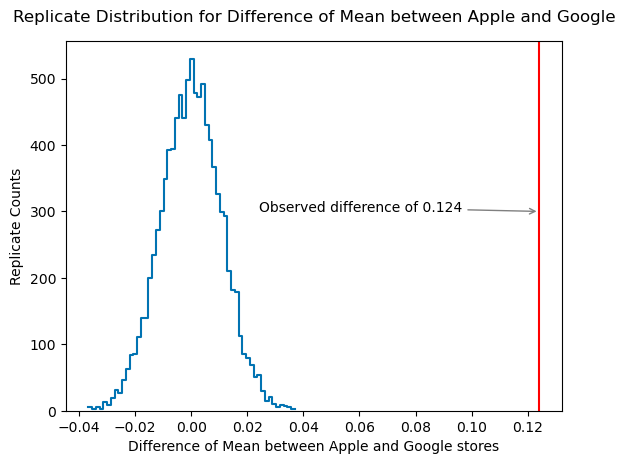

In [23]:
_ = sns.histplot(data = permutation_replicates,
                element = 'step',
                fill = False)

_ = plt.axvline(diff_of_mean(apple,google), color='r')
plt.title("Replicate Distribution for Difference of Mean between Apple and Google", y =1.03)
plt.xlabel("Difference of Mean between Apple and Google stores")
plt.ylabel("Replicate Counts")

plt.annotate("Observed difference of 0.124", xy = (diff_of_mean(apple,google),300), 
xytext = (diff_of_mean(apple,google)-0.10,300), 
arrowprops = {"arrowstyle":"->", "color":"gray"})

plt.savefig('Replicate Distribution for Difference of Mean between Apple and Google.png',
            dpi = 300, 
            format = 'png')

plt.show()

In [24]:
p_value = np.sum(permutation_replicates[permutation_replicates > diff_of_mean(apple, google)])/len(permutation_replicates)
print('p-value for hypothesis test: ',p_value)

p-value for hypothesis test:  0.0


# Conclusion:

Based on 10,000 replicates generated from the permutation test, a p-value of 0 allows the rejection of the null hypothesis.
Rephrasing, after performing 10,000 replicates, there is not 1 instance where the difference of means is as great as the observed difference of 0.124 between the Apple and Google store.

The observed difference of 0.124 in the mean of app ratings between the Apple and Google store is significant.

Thus, it is recommended that the client focus on developing the app for Google Play Store first.

# Further study:

One assumption in this study was that all apps across categories are equal. EDA with further breakdown maybe required to better understand the category that best matches the app to be developed.

Also, the price of the apps were ignored in this study. Understanding any differences in ratings caused by price could be helpful in determining the price of the app.